# CNN Interpretation - Image Generation

**Note**: This notebook is desinged to run on CPU (no GPU) runtime.

**[CII-01]**

Install libraries.

In [1]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[CII-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

import jax, optax
from jax import grad, random, numpy as jnp
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import freeze, unfreeze

plt.rcParams.update({'font.size': 12})

**[CII-03]**

Define a model to apply the fixed convolutional filters.

In [3]:
class FixedConvFilterModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape([-1, 28, 28, 1])
        x = nn.Conv(features=2, kernel_size=(5, 5), use_bias=False)(x)
        x = jnp.abs(x)
        x = nn.relu(x-0.2)
        return x

**[CII-04]**

Define the fixed convolutional filters to extract vartical and horizontal edges.

In [4]:
filter0 = np.array([[ 2, 1, 0,-1,-2],
                    [ 3, 2, 0,-2,-3],
                    [ 4, 3, 0,-3,-4],
                    [ 3, 2, 0,-2,-3],
                    [ 2, 1, 0,-1,-2]]) / 23.0
filter1 = np.array([[ 2, 3, 4, 3, 2],
                    [ 1, 2, 3, 2, 1],
                    [ 0, 0, 0, 0, 0],
                    [-1,-2,-3,-2,-1],
                    [-2,-3,-4,-3,-2]]) / 23.0

filter_array = np.zeros([5, 5, 1, 2])
filter_array[:, :, 0, 0] = filter0
filter_array[:, :, 0, 1] = filter1

**[CII-05]**

Create a TrainState object containing the fixed convolutional filters.

In [5]:
variables = FixedConvFilterModel().init(
    random.PRNGKey(0), jnp.zeros([1, 28*28]))

params = unfreeze(variables['params'])
params['Conv_0']['kernel'] = jnp.asarray(filter_array)
new_params = freeze(params)

state = train_state.TrainState.create(
    apply_fn=FixedConvFilterModel().apply,
    params=new_params,
    tx=optax.adam(learning_rate=0.001))

**[CII-06]**

Define a function to generate images that miximize the output from convolutional filters.

In [6]:
@jax.jit
def filter_output_mean(image, i):
    filter_output = state.apply_fn(
        {'params': state.params}, jnp.asarray([image]))
    return jnp.mean(filter_output[0, :, :, i])


def create_pattern(i):
    key = random.fold_in(random.PRNGKey(0), i)
    image = random.normal(key, (28, 28)) * 0.1 + 0.5

    epsilon = 1000
    for _ in range(20):
        image += epsilon * jax.grad(filter_output_mean)(image, i)
        epsilon *= 0.9

    image -= jnp.min(image)
    image /= jnp.max(image)

    return jax.device_get(image)

**[CII-07]**

Generate images and show the result.

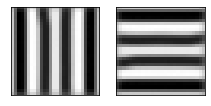

In [7]:
fig = plt.figure(figsize=(30, 15))
for i in range(2):
    img = create_pattern(i)
    subplot = fig.add_subplot(2, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape([28, 28]), vmin=0, vmax=1, cmap=plt.cm.gray_r)

**[CII-08]**

Defnine a dual layer CNN model.

In [8]:
class DoubleLayerCNN(nn.Module):
    @nn.compact
    def __call__(self, x, get_filter_output1=False, get_filter_output2=False):
        x = x.reshape([-1, 28, 28, 1])

        x = nn.Conv(features=32, kernel_size=(5, 5), use_bias=True)(x)
        x = nn.relu(x)
        if get_filter_output1:
            return x
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=64, kernel_size=(5, 5), use_bias=True)(x)
        x = nn.relu(x)
        if get_filter_output2:
            return x
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape([x.shape[0], -1]) # Flatten
        x = nn.Dense(features=1024)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.softmax(x)
        return x

**[CII-09]**

Create a TrainState object.

In [9]:
class TrainState(train_state.TrainState):
    epoch: int
    dropout_rng: type(random.PRNGKey(0))


variables = DoubleLayerCNN().init(random.PRNGKey(0), jnp.zeros([1, 28*28]))

state = TrainState.create(
    apply_fn=DoubleLayerCNN().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001),
    dropout_rng=random.PRNGKey(0),
    epoch=0)

**[CII-10]**

Mount Google Drive contents.

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**[CII-11]**

Confirm that a checkpoint file is stored in the folder.

In [11]:
!ls -lh '/content/gdrive/My Drive/checkpoints/'

total 75M
-rw------- 1 root root 38M Oct 13 11:18 DoubleLayerCNN_checkpoint_16
-rw------- 1 root root 37M Oct 13 11:19 SingleLayerCNN_checkpoint_16


**[CII-12]**

Restore the checkpoint.

In [12]:
state = checkpoints.restore_checkpoint(
    ckpt_dir='/content/gdrive/My Drive/checkpoints/',
    prefix='DoubleLayerCNN_checkpoint_',
    target=state)

**[CII-13]**

Define a function to generate images that miximize the output from convolutional filters.

In [13]:
@jax.jit
def first_filter_output_mean(image, i):
    filter_output = state.apply_fn(
        {'params': state.params}, jnp.asarray([image]),
        get_filter_output1=True)
    return jnp.mean(filter_output[0, :, :, i])


@jax.jit
def second_filter_output_mean(image, i):
    filter_output = state.apply_fn(
        {'params': state.params}, jnp.asarray([image]),
        get_filter_output2=True)
    return jnp.mean(filter_output[0, :, :, i])


def create_pattern(filter_output_mean, i):
    key = random.fold_in(random.PRNGKey(0), i)
    image = random.normal(key, (28, 28)) * 0.1 + 0.5

    epsilon = 1000
    for _ in range(50):
        image += epsilon * jax.grad(filter_output_mean)(image, i)
        epsilon *= 0.9

    image -= jnp.min(image)
    image /= jnp.max(image)

    return jax.device_get(image)

**[CII-14]**

Generate images and show the result for the first layer.

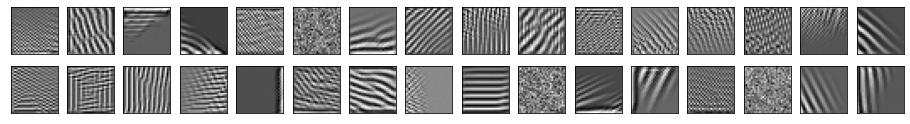

In [14]:
fig = plt.figure(figsize=(16, 2))
for i in range(32):
  img = create_pattern(first_filter_output_mean, i)
  subplot = fig.add_subplot(2, 16, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(img.reshape(28, 28), cmap=plt.cm.gray_r)

**[CII-15]**

Generate images and show the result for the second layer.

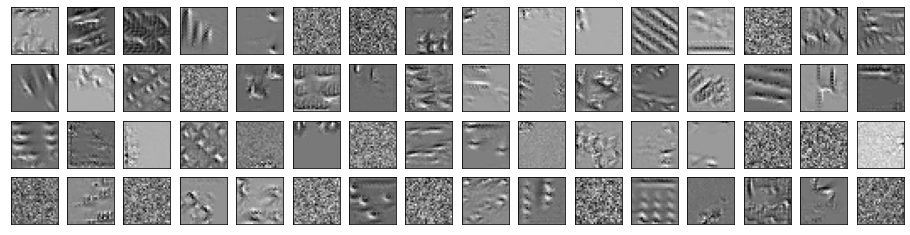

In [15]:
fig = plt.figure(figsize=(16, 4))
for i in range(64):
    img = create_pattern(second_filter_output_mean, i)
    subplot = fig.add_subplot(4, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), cmap=plt.cm.gray_r)